In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Problem Type

IC<sub>50</sub> determination is a commonplace problem type for experimental biochemists. The goal is to determine the concentration of an inhibitor that causes a protein to have 1/2 as much activity as without the inhibitor.

Classically, this is done by fitting a logistic function of some sort, where the IC<sub>50</sub> is a parameter in the model. We then want to determine IC<sub>50</sub>, given the data at hand.

In the implementation here, we allow for multi-drug IC<sub>50</sub> determination. Additionally, I also show how we can have a mix of noisy data and have non-uniform coverage over the drug concentration space, and still come to a fairly precise determination of the IC<sub>50</sub> values as long as we have dense enough data around the true IC50 area. The simulated data below assumes that a first-pass experiment was done over a wide range of data points, followed by a second-pass set of experiments where a range of concentrations was filled in with more resolution.

## Data structure

To use it with this model, the data should be structured as such:

- Each row is one measurement for one concentration of drug.
- The columns should indicate, at the minimum:
    - What treatment group the sample belonged to.
    - The measured value.

## Extensions to the model

None

## Reporting summarized findings

Here are examples of how to summarize the findings.

> The IC<sub>50</sub> of drug X was `mean` (95% HPD: [`lower`, `upper`]).

## Other notes

None

In [18]:
# Generate some fake data.
x_concs = np.concatenate([np.arange(0, 100, 10), np.arange(5, 21, 1), np.arange(40, 51, 1), np.arange(85, 96, 1)]).reshape(-1, 1)
log_xconcs = np.log(x_concs)
ic50_true = np.array([42, 13, 88])
ic50_true = ic50_true.reshape(-1, ic50_true.shape[0])
beta_true = 1
slope_true = 1
intercept_true = 150
# y_true = slope_true * x_concs + intercept_true

y_true = beta_true / (1 + np.exp(x_concs - ic50_true))

y_noisy = y_true + np.random.normal(0, 0.15, size=y_true.shape)  # homoskedastic error
y_noisy[0:5]

array([[ 1.01827609,  1.00676434,  1.13463151],
       [ 0.95736394,  0.99967829,  1.17340796],
       [ 0.93287753, -0.01882115,  0.87778756],
       [ 1.08083158,  0.07231967,  0.98512075],
       [ 1.16101251,  0.2298778 ,  0.90348387]])

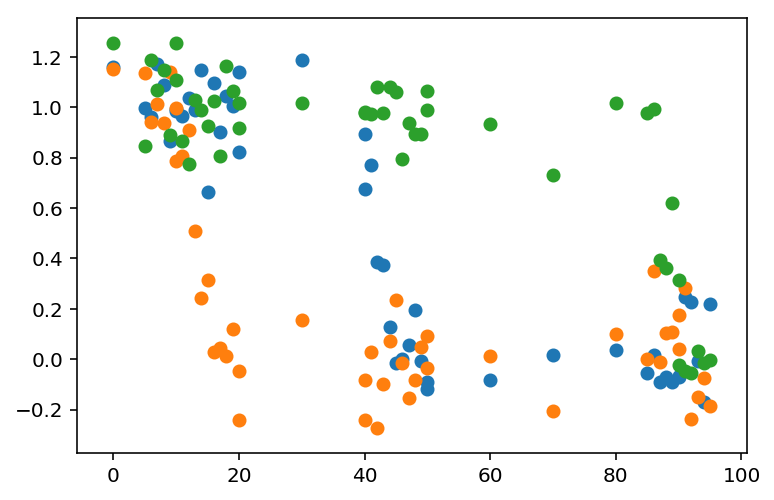

In [3]:
plt.scatter(x_concs, y_noisy[:, 0])
plt.scatter(x_concs, y_noisy[:, 1])
plt.scatter(x_concs, y_noisy[:, 2])

Note how there's sparse coverage in the regions outside of the true IC<sub>50</sub>s.

In [17]:
concentrations = np.concatenate([x_concs] * ic50_true.shape[1])
concentrations[::10]  # print every 10th 

array([[ 0],
       [ 5],
       [15],
       [44],
       [88],
       [20],
       [ 7],
       [17],
       [46],
       [90],
       [40],
       [ 9],
       [19],
       [48],
       [92]])

In [5]:
concentrations.shape

(144, 1)

In [14]:
y_noisy.flatten(order='F').shape

(144,)

In [7]:
x_concs.shape[0]

48

In [8]:
data = pd.DataFrame()
data['concentrations'] = concentrations.reshape(concentrations.shape[0],)
data['measurements'] = y_noisy.flatten(order='F')

drugs = []
for i in range(ic50_true.shape[1]):
    drugs.extend([i] * x_concs.shape[0])
data['drug'] = drugs

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

le = LabelEncoder()
data['idxs'] = le.fit_transform(data['drug'])

# Normalize data['measurements'] to 0-1
# mms = MinMaxScaler()
# data['measurements'] = mms.fit_transform(data['measurements'].values.reshape(-1, 1))

In [15]:
data.head()

,concentrations,measurements,drug,idxs
0,0,1.160692,0,0
1,10,0.985928,0,0
2,20,0.821160,0,0
3,30,1.186858,0,0
4,40,0.892651,0,0


In [10]:
with pm.Model() as model:
    beta = pm.Normal('beta', mu=0, sd=100**2, shape=len(set(data['idxs'])))    
    noise = pm.HalfCauchy('noise', beta=100**2, shape=len(set(data['idxs'])))
    ic50 = pm.Normal('IC50', sd=100**2, shape=len(set(data['idxs'])))
    measurements = beta[data['idxs']] / (1 + np.exp(data['concentrations'].values - ic50[data['idxs']]))

    
    y_like = pm.Normal('y_like', mu=measurements, sd=noise[data['idxs']], observed=data['measurements'])

In [11]:
with model:
    trace = pm.sample(draws=10000, step=pm.Metropolis(), start=pm.find_MAP())  
    # trace = pm.sample(draws=2000)  # ADVI init is fast, but NUTS sampling is slow later on.

Optimization terminated successfully.
         Current function value: 97.179436
         Iterations: 68
         Function evaluations: 97
         Gradient evaluations: 97


100%|██████████| 10000/10000 [00:02<00:00, 3511.39it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8dc956ac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc8d5d15f60>]], dtype=object)

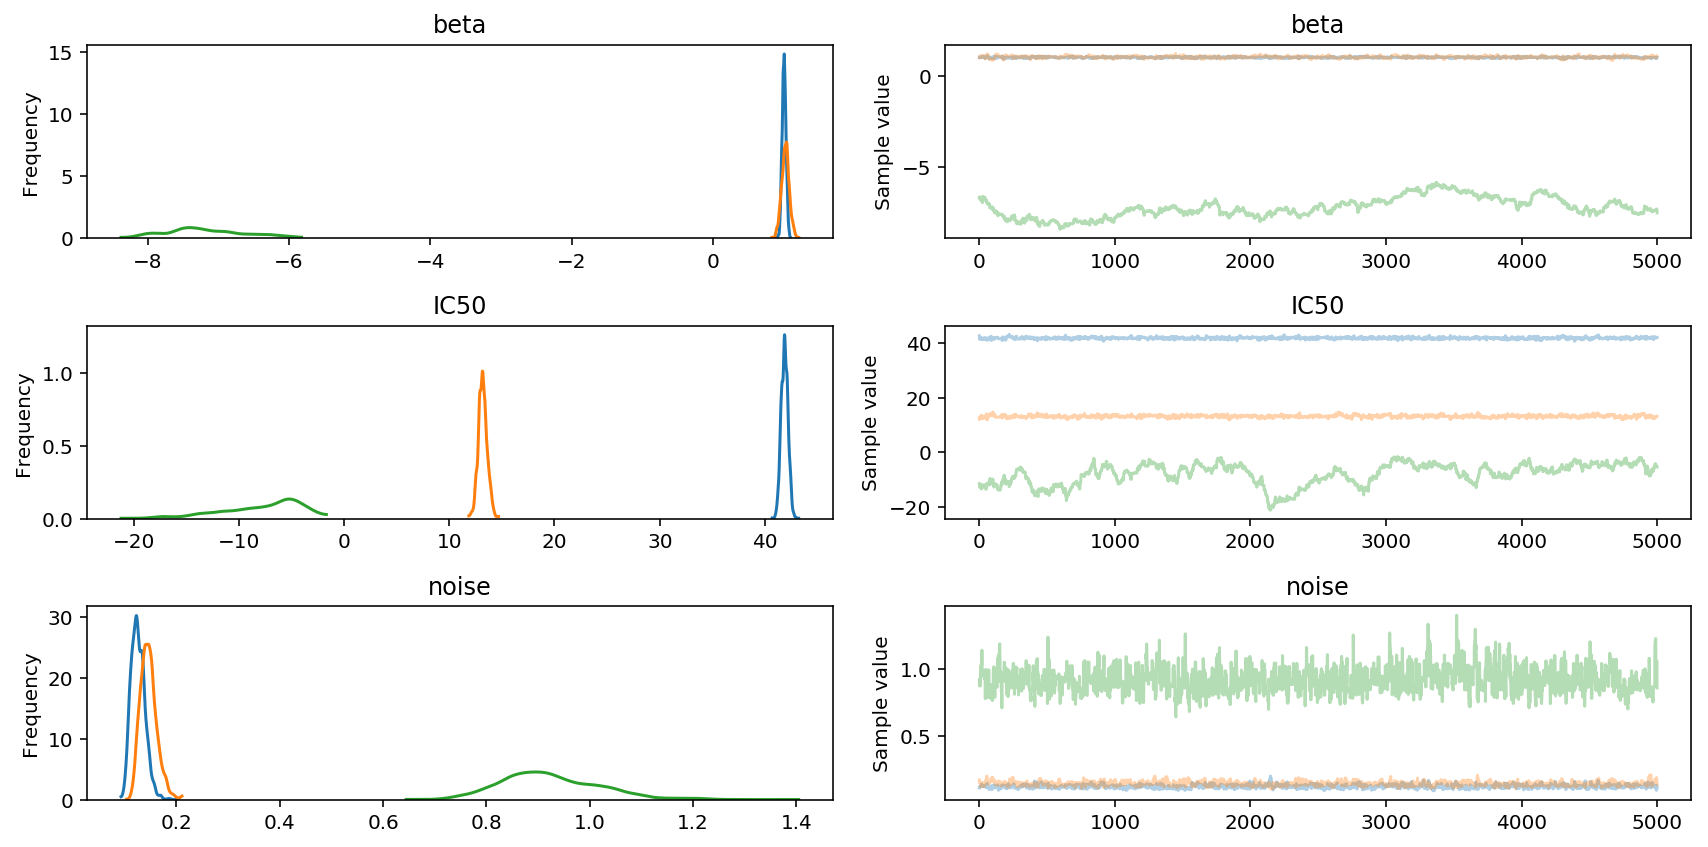

In [12]:
pm.traceplot(trace[5000:])

Note the posterior distributions around the IC50s are fairly nice and tight.

In [13]:
pm.summary(trace[5000:])


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.005            0.027            0.001            [0.956, 1.060]
  1.024            0.054            0.003            [0.921, 1.138]
  -7.189           0.543            0.053            [-8.117, -6.121]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.953          0.988          1.005          1.023          1.059
  0.912          0.988          1.024          1.057          1.134
  -8.097         -7.557         -7.263         -6.835         -6.059


IC50:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  41.860           0.326            0.013            [41.226, 42.472]
  13.185           0.426            0.021            [12.4